Multi-level Perturbed Unit Gradient Descent, MPUGD

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data  import Subset, DataLoader
from sklearn.model_selection  import train_test_split 

import torchvision
import torchvision.transforms as transforms
from types import SimpleNamespace 
import matplotlib.pyplot  as plt
import numpy as np 

from optimizers import *
from upanets import UPANets
from torchsummary import summary
import time, copy,timm
import json
import random 
import os
from train import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
args = SimpleNamespace(
    datasets='cifar_10',
    batch_size = 500,
    seed = 42,
    lr=0.1, 
    momentum=0.9,
    wd = 0.0005,
    blocks = 1,
    filters = 16,
    epochs = 400,
    start_epochs = 8
    )

In [3]:
def set_all_seeds(seed=42):
    # Python原生随机 
    random.seed(seed) 
    # NumPy随机 
    np.random.seed(seed) 
    # PyTorch随机 
    torch.manual_seed(seed) 
    # CUDA随机（GPU相关）
    torch.cuda.manual_seed_all(seed) 
    # CUDNN确定性模式 
    torch.backends.cudnn.deterministic  = True 
    torch.backends.cudnn.benchmark  = False 
 
set_all_seeds(args.seed)  

In [4]:
print(device)

cuda


In [5]:
img_size = 32 # default image size for Cifar-10
im_dimention = 32
cifar_10_mean = [0.4914, 0.4822, 0.4465] 
cifar_10_std = [0.2023, 0.1994, 0.2010]
cifar_100_mean = [0.5071, 0.4867, 0.4408]
cifar_100_std = [0.2673, 0.2564, 0.2762]

if args.datasets == 'cifar_10':
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.RandomRotation(15,),
            transforms.RandomCrop(im_dimention),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
            # transforms.Lambda(lambda x: x.to(torch.float16))    # 最终输出FP16
        ]),
        # 'valid': transforms.Compose([
        #     transforms.Resize((im_dimention,im_dimention)),
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        # ]),
        'test': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        ]),
    }
 
    full_trainset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=True, download=True, transform=data_transforms['train'])
    testset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=False, download=True, transform=data_transforms['test'])
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=args.batch_size, shuffle=False, num_workers=0)
    Num_class = 10

if args.datasets == 'cifar_100':
    data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(im_dimention),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    # 'valid': transforms.Compose([
    #     transforms.Resize((im_dimention,im_dimention)),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    # ]),
    'test': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    }
    full_trainset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=True, download=True, transform=data_transforms['train'])
    testset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=False, download=True, transform=data_transforms['test'])
    testloader = DataLoader(
        testset, batch_size=args.batch_size, shuffle=False,sampler=torch.utils.data.SequentialSampler(testset),  num_workers=0)
    Num_class = 100

# # 获取所有样本的标签 
# labels = [full_trainset[i][1] for i in range(len(full_trainset))]

# # 分层划分（stratify参数确保比例）
# train_idx, val_idx = train_test_split(
#     range(len(full_trainset)),
#     test_size=0.2,
#     shuffle=True,
#     stratify=labels,
#     random_state=args.seed  
# )

# train_data = np.stack([full_trainset.data[i]  for i in train_idx]) 
# train_targets = [full_trainset.targets[i] for i in train_idx] 
# val_data = np.stack([full_trainset.data[i]  for i in val_idx]) 
# val_targets = [full_trainset.targets[i] for i in val_idx] 

# valset = full_trainset
# valset.data = val_data
# valset.targets = val_targets
# valset.transform = data_transforms['valid']

# trainset = copy.deepcopy(valset)
# trainset.data = train_data
# trainset.targets = train_targets
# trainset.transform = data_transforms['train']

# trainloader = {
#     'train':DataLoader(
#     trainset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(trainset), num_workers=0),
#     'valid':DataLoader(
#     valset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(valset), num_workers=0)}

# dataset_sizes = {
#     'train': len(trainset),
#     'valid': len(valset),            
                #  }

trainloader = {
    'train':DataLoader(
    full_trainset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(full_trainset), num_workers=0),
    'valid':testloader
}

dataset_sizes = {
    'train': len(full_trainset),
    'valid': len(testset),      
}
print(dataset_sizes)


{'train': 50000, 'valid': 10000}


In [6]:
print(timm.list_models('*vit_tiny_patch16_224*')) 

['vit_tiny_patch16_224']


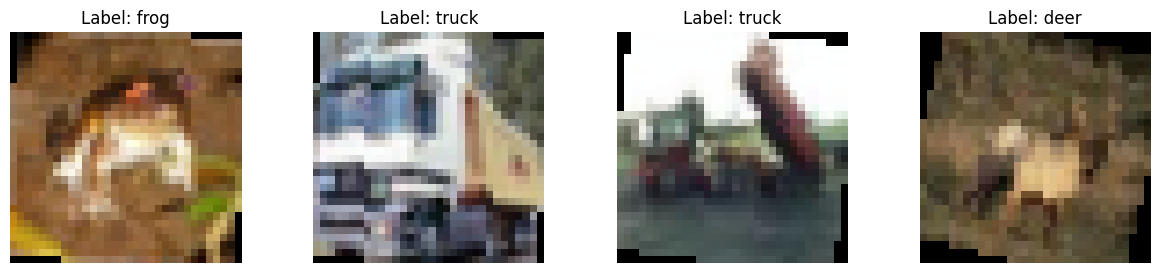

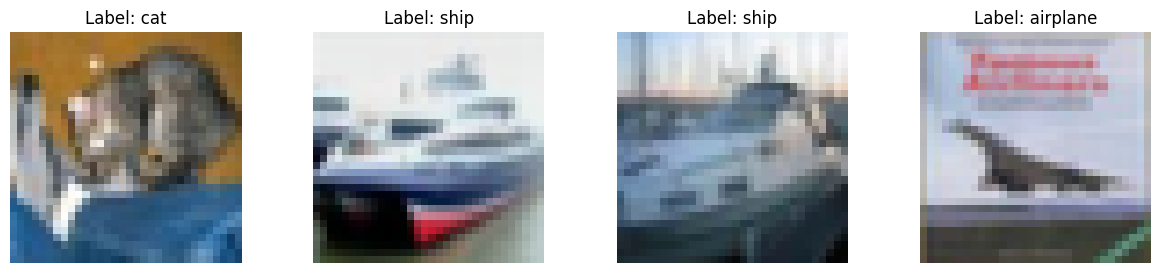

In [7]:
# from torchvision.transforms.functional  import to_pil_image 
# 反归一化转换（需与transform中的参数对应）
inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010]
)
 
def show_images(loader, num_images=4):
    # 获取一个batch的数据 
    # images, labels = next(iter(loader))
    for batch_idx, (images, labels) in enumerate(loader):
        if batch_idx == 0:  # 只取第一个batch 
            break 

    # 创建子图 
    fig, axes = plt.subplots(1,  num_images, figsize=(15, 3))
    
    for i in range(num_images):
        # 反归一化+通道顺序调整 
        img = inv_normalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img,  0, 1)  # 处理浮点误差 
        
        # 显示图像及标签 
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {full_trainset.classes[labels[i]]}") 
        axes[i].axis('off')
    
    plt.show() 
 
show_images(trainloader['train'])
show_images(testloader)

In [8]:
model_path = "./model/" + args.datasets + "/benckmark.pth"
if os.path.exists(model_path):
    net_benckmark_data = torch.load(model_path,  map_location='cpu')
    benckmark_state_dict = net_benckmark_data['model_state_dict'] 
else:
    net_benchmark = UPANets(args.filters, Num_class, args.blocks, img_size)
    torch.save({
        'model_state_dict': net_benchmark.state_dict()
    }, model_path)
    benckmark_state_dict = net_benchmark.state_dict()

def tensor_to_serializable(obj):
    if isinstance(obj, (np.float32,  np.float64)):   # 处理NumPy浮点数
        return float(obj)
    elif isinstance(obj, np.integer):               # 处理NumPy整数 
        return int(obj)
    elif isinstance(obj, torch.Tensor):            # 处理PyTorch Tensor 
        return obj.item()  if obj.numel()  == 1 else obj.tolist() 
    elif isinstance(obj, (np.ndarray)):             # 处理NumPy数组 
        return obj.tolist() 
    elif hasattr(obj, '__dict__'):                 # 处理自定义对象（可选）
        return obj.__dict__
    return obj 


In [9]:
# net_pugdt_delta = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdt_delta.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdt_delta.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdt_delta = torch.nn.DataParallel(net_pugdt_delta)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXT(net_pugdt_delta.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdt_delta, metricst_delta = train_model_timing_delta(net_pugdt_delta, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes, int(args.epochs/10), 0.01, 10) 

# model_path = "./model/"+args.datasets+"/pugdt_delta_" + str(args.epochs) + "xi" + str(args.epochs/10) + "mu0.01_t10.pth"
# torch.save({
#     'model_state_dict': net_pugdt_delta.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdt_delta_" + str(args.epochs) + "xi" + str(args.epochs/10) + "mu0.01_t10.json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricst_delta,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [10]:
# net_pugdt_var = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdt_var.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdt_var.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdt_var = torch.nn.DataParallel(net_pugdt_var)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXT(net_pugdt_var.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdt_var, metricst_var = train_model_timing_var(net_pugdt_var, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes, int(args.epochs/10), 0.015, 10) 

# model_path = "./model/"+args.datasets+"/pugdt_var_" + str(args.epochs) + "init_t" + str(args.epochs/10) + "gamma0.015_k10.pth"
# torch.save({
#     'model_state_dict': net_pugdt_var.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdt_var_" + str(args.epochs) + "init_t" + str(args.epochs/10) + "gamma0.015_k10.json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricst_var,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [11]:
# net = UPANets(args.filters, Num_class, args.blocks, img_size)
# net.load_state_dict(copy.deepcopy(benckmark_state_dict))

# criterion = torch.nn.CrossEntropyLoss()

# net.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True

# optimizer = optim.SGD(net.parameters(),
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net, metrics_org = train_model_org(net, criterion, optimizer, scheduler, args.epochs * 2, trainloader, device, dataset_sizes) 

# # 保存模型架构+参数+优化器状态（完整恢复训练）
# model_path = "./model/"+args.datasets+"/org" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/org_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics_org, f, default=tensor_to_serializable, ensure_ascii=False, indent=4)
 
# # 加载 

# # checkpoint = torch.load('full_model_checkpoint.pth',  map_location='cpu')  # 先加载到CPU避免设备冲突 
# # 模型结构需提前定义（需与保存时一致）
# # model = YourModelClass()  
# # model.load_state_dict(checkpoint['model_state_dict']) 
 
# # # 恢复优化器和训练状态 
# # optimizer = torch.optim.Adam(model.parameters())  
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 
# # with open('data.json',  'r', encoding='utf-8') as f:
# #     loaded_dict = json.load(f) 


# # summary(net, (3, img_size, img_size))


In [12]:
net_pugdr_sin = UPANets(args.filters, Num_class, args.blocks, img_size)
net_pugdr_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugdr_sin.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(net_pugdr_sin)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXR(net_pugdr_sin.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.5, 
                max_beta = 1.5, 
                method = 'sin',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugdr_sin, metricsr_sin = train_model_alpha(net_pugdr_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugdr_sin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugdr_sin.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugdr_sin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399


d:\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


241.7836492061615
Epoch 1/399
243.46752834320068
Epoch 2/399
246.0016748905182
Epoch 3/399
244.0839307308197
Epoch 4/399
244.4616322517395
Epoch 5/399
244.92393517494202
Epoch 6/399
241.48592495918274
Epoch 7/399
240.06820273399353
Epoch 8/399
240.20319437980652
Epoch 9/399
240.16366243362427
Epoch 10/399
239.99059128761292
Epoch 11/399
240.53280353546143
Epoch 12/399
240.393301486969
Epoch 13/399
240.57809853553772
Epoch 14/399
243.5778353214264
Epoch 15/399
247.7289810180664
Epoch 16/399
246.7749547958374
Epoch 17/399
247.61413049697876
Epoch 18/399
247.101238489151
Epoch 19/399
248.3034393787384
Epoch 20/399
247.9653663635254
Epoch 21/399
247.60131192207336
Epoch 22/399
247.05935883522034
Epoch 23/399
245.59500741958618
Epoch 24/399
242.21474480628967
Epoch 25/399
241.72860956192017
Epoch 26/399
241.42920541763306
Epoch 27/399
241.5365972518921
Epoch 28/399
241.6073076725006
Epoch 29/399
241.39691996574402
Epoch 30/399
241.8632116317749
Epoch 31/399
242.09808349609375
Epoch 32/399
2

In [23]:
net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)
net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugdr_cos.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXR(net_pugdr_cos.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.5, 
                max_beta = 1.5, 
                method = 'cos',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugdr_cos, metricsr_sin = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugdr_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugdr_cos.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugdr_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
249.75502681732178
Epoch 1/399
252.5345275402069
Epoch 2/399
251.52871227264404
Epoch 3/399
251.5738582611084
Epoch 4/399
252.28443241119385
Epoch 5/399
253.63430190086365
Epoch 6/399
252.22831988334656
Epoch 7/399
246.8425886631012
Epoch 8/399
246.66606187820435
Epoch 9/399
247.3492419719696
Epoch 10/399
246.41909289360046
Epoch 11/399
246.8299331665039
Epoch 12/399
247.09714698791504
Epoch 13/399
246.70776844024658
Epoch 14/399
246.68972444534302
Epoch 15/399
246.72980976104736
Epoch 16/399
246.73444247245789
Epoch 17/399
246.63131523132324
Epoch 18/399
246.88073110580444
Epoch 19/399
246.48232579231262
Epoch 20/399
247.34051370620728
Epoch 21/399
246.77393102645874
Epoch 22/399
247.11726260185242
Epoch 23/399
247.02446031570435
Epoch 24/399
246.4842028617859
Epoch 25/399
250.5487163066864
Epoch 26/399
252.09057068824768
Epoch 27/399
252.613783121109
Epoch 28/399
253.13262009620667
Epoch 29/399
254.28450202941895
Epoch 30/399
248.11770105361938
Epoch 31/399
246.8100705146

KeyboardInterrupt: 

In [14]:
# net_pugds_cos = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_cos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_cos = torch.nn.DataParallel(net_pugds_cos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_cos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.0, 
#                 max_beta = 2,
#                 method = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugds_cos, metricss_cos = train_model_alpha(net_pugds_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_cos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_cos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [15]:
# net_pugds_sin = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_sin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_sin = torch.nn.DataParallel(net_pugds_sin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_sin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.0, 
#                 max_beta = 2,
#                 method = 'sin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugds_sin, metricss_sin = train_model_alpha(net_pugds_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_sin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_sin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_sin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [16]:
# net_pugd = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugd.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugd.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugd)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDX(net_pugd.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugd, metrics0 = train_model(net_pugd, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugd" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugd.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugd_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [17]:
# net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_cos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_cos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.01, 
#                 max_beta = 2, 
#                 method = 'icos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdr_cos, metricsr_cos = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_cos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_cos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [18]:
# net_pugdr_sin = UPANets(args.filters, Num_class, args.blocks, img_size)
# net_pugdr_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_sin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_sin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_sin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.01, 
#                 max_beta = 2, 
#                 method = 'isin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugdr_sin, metricsr_sin = train_model_alpha(net_pugdr_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_isin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_sin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_isin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [19]:
# net_pugds_icos = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_icos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_icos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_icos = torch.nn.DataParallel(net_pugds_icos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_icos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.8, 
#                 max_beta = 3, 
#                 method = 'icos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugds_icos, metricss_icos = train_model_alpha(net_pugds_icos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_icos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_icos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [20]:
# net_pugds_isin = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_isin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_isin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_isin = torch.nn.DataParallel(net_pugds_isin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_isin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.8, 
#                 max_beta = 3, 
#                 method = 'isin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugds_isin, metricss_isin = train_model_alpha(net_pugds_isin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_isin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_isin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_isin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_isin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [21]:
# print(new_head.__dict__)
# print(vars(new_head))
# import optimizers
# import importlib 
# importlib.reload(optimizers)   
# from optimizers import *

In [22]:
# model_ft2 = timm.create_model('mobilenetv3_small_100', pretrained=True, num_classes=Num_class)
# original_head = model_ft2.classifier   # MobileNetV3的分类头名为classifier 
# new_head = nn.Linear(original_head.in_features,  Num_class)
# model_ft2 = model_ft2.to(device)
# criterion = torch.nn.CrossEntropyLoss()


# base_optimizer2 = optim.SGD
# optimizer2 = PUGD2(model_ft2.parameters(),
#                  base_optimizer2,
#                  lr=args.lr,
#                  momentum=args.momentum,
#                  weight_decay=args.wd,
#                  )


# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)

# model_ft2 = train_model2(model_ft2, criterion, optimizer2, exp_lr_scheduler, num_epochs=20) 